# 1. Introduction 




L'apprentissage séquence-à-séquence (Seq2Seq) est un modèle de traitement automatique des langues qui a été introduit pour la première fois en 2014 dans le papier intitulé [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/pdf/1409.3215.pdf) de Ilya Sutskever, Oriol Vinyals et Quoc V. Le. Ce papier a marqué une révolution dans le domaine de la compréhension automatique des langues en introduisant l'utilisation de réseaux de neurones pour l'apprentissage séquence-à-séquence.

Avant l'arrivée de ce papier, les modèles pour le traitement automatique des langues étaient généralement basés sur des méthodes statistiques et de la logique floue. Cependant, ces méthodes ont montré leurs limites pour traiter des tâches complexes telles que la traduction automatique. Le papier de Sutskever et al. a proposé une nouvelle approche basée sur les réseaux de neurones qui a permis de surmonter ces limites et de obtenir des résultats très prometteurs dans des tâches telles que la traduction automatique.

# 2. Modèle Seq2Seq


Les modèles de séquence à séquence (seq2seq) les plus courants sont les modèles encodeur-décodeur, qui utilisent généralement un réseau neuronal récurrent (RNN) pour encoder la phrase source (entrée) en un seul vecteur. Dans ce notebook, nous ferons référence à ce vecteur unique en tant que vecteur de contexte. Nous pouvons considérer le vecteur de contexte comme étant une représentation abstraite de la phrase d'entrée entière. Ce vecteur est ensuite décodé par un second RNN qui apprend à générer la phrase cible (sortie) mot par mot.
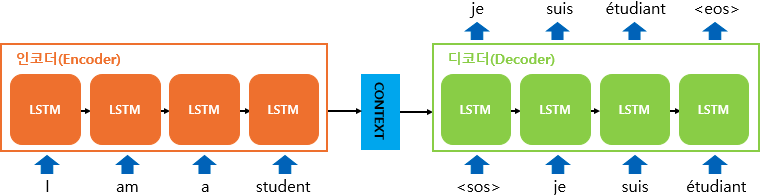

L'image ci-dessus montre un exemple de traduction. L'entrée, "I am a student" est passé à l'encoder (LSTM). Notons que cette image est simplifiée, en effet avant de passer la phrase à l'encoder, on la passe d'abord pas la couche *embedding*, qui a pour rôle de convertir les mots en entrée en un vecteur de caractéristiques numériques. 

A chaque pas de temps, l'entrée de l'encoder est donc l'embedding du mot actuel qu'on va le noter $e(x_t)$, ainsi que le hidden state du pas de temps précédent, $h_{t-1}$, et l'encoder LSTM donne en sortie un nouveau hidden state $h_{t}$. On peut voir le hidden state comme un vecteur qui représente la phrase. 

Une fois le dernier mot de la phrase a été passé au LSTM à travers la couche d'*embedding*,  on utilise le dernier hidden state, comme le vecteur de contexte. Ce vecteur représente donc la phrase entière.

Une fois qu'on a notre vecteur de contexte, on peut commencer à le décoder pour avoir notre phrase de sortie "je suis étudiant", notons qu'on ajoute `<sos>` et `<eos>` pour préciser le début et la fin de la phrase. A chaque pas de temps, l'entrée du décodeur est l'embedding du mot  qu'on va noter cette fois $d(y_t)$, ainsi que le hidden state du pas de temps précédent noté cette fois $s_{t-1}$, on initialise donc le hidden state du décodeur, $s_0$ par le vecteur contexte obtenu précédemment.

Dans le décodeur, on a besoin d'aller du hidden state à un certain mot, donc à chaque pas de temps, on va passer le hidden state $s_t$ à une couche linéaire afin de prédire ce qu'on pense être le prochain mot dans la phrase, $\hat{y}_t$.

$$\hat{y}_t = f(s_t)$$

Les mots dans le décodeurs sont générés un par un. On utilise `<sos>` pour la première entrée du décodeur, pour les entrées suivantes, on peut utiliser le dernier mot prédit par le décodeur $\hat{y}_{t-1}$, comme on peut utiliser le vrai mot ${y}_{t-1}$, ce qui s'appelle le teacher forcing, pour plus d'info cliquez [ici](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/). 

Notons que lors de l'apprentissage du modèle, on connaît le nombre exacte du mot qu'on cherche à prédire, donc on arrête de générer des mots lorsqu'on atteint le nombre voulu, cependant en cas réel, on continue de générer des mots jusqu'on génère `<sos>` ou bien après un certain nombre de mot soient générer.

Une fois qu'on a prédit notre phrase, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, on la compare à notre vraie phrase $Y = \{ y_1, y_2, ..., y_T \}$, afin de calculer la fonction loss. On utilise donc cette fonction pour mettre à jour tous les paramèteres du modèle.


# 3. Préparation des données

On va utiliser la base de donnée de traduction WMT'14 utilisé dans le papier de recherche.

 On exécute la cellule suivante afin d'avoir les données :

In [ ]:
!wget https://www.statmt.org/europarl/v7/fr-en.tgz

--2023-01-30 13:41:02--  https://www.statmt.org/europarl/v7/fr-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202718517 (193M) [application/x-gzip]
Saving to: ‘fr-en.tgz’

fr-en.tgz           100%[===================>] 193.33M  2.20MB/s    in 87s     

2023-01-30 13:42:29 (2.21 MB/s) - ‘fr-en.tgz’ saved [202718517/202718517]



Après on va extraire les deux fichiers contenues dans le dossier *fr-en.tgz*

In [ ]:
!tar -xzvf fr-en.tgz

europarl-v7.fr-en.en
europarl-v7.fr-en.fr




*   europarl-v7.fr-en.en contient des phrases en anglais
*   europarl-v7.fr-en.fr contient des phrases en français

On va traiter et combiner les deux fichiers afin de créer notre jeu de données.



On commence par importer les bibliothèques utiles :

In [ ]:
import string
import re
from pickle import dump
from unicodedata import normalize

Commençons par charger les fichiers de données.

Nous pouvons charger chaque fichier sous forme de chaîne de caractère. Étant donné que les fichiers contiennent des caractères Unicode, nous devons spécifier un encodage lors du chargement des fichiers en tant que texte. Dans ce cas, nous utiliserons UTF-8 qui gérera facilement les caractères Unicode dans les deux fichiers.

La fonction ci-dessous, nommée load_doc() , chargera un fichier donné et le renverra sous forme de blob de texte.



In [ ]:
# Charger les données en mémoire
def load_doc(filename):
	# Ouvrir le fichier en lecture uniquement
	file = open(filename, mode='rt', encoding='utf-8')
	# On lit tout le texte
	text = file.read()
	# On ferme le fichier
	file.close()
	return text

Ensuite, nous pouvons diviser le fichier en phrases.

Généralement, un énoncé est stocké sur chaque ligne. Nous pouvons les traiter comme des phrases et diviser le fichier par des caractères de nouvelle ligne. La fonction to_sentences() ci-dessous divisera un document chargé.

In [ ]:
# on split un document chargé en phrase
def to_sentences(doc):
	return doc.strip().split('\n')

Les données nécessitent un minimum de nettoyage avant d'être utilisées pour former un modèle de traduction neuronale.

En regardant quelques exemples de texte, un nettoyage minimal du texte peut inclure :

* Tokenisation du texte par un espace blanc.
* Normalisation de la phrase en minuscule.
* Suppression de la ponctuation de chaque mot.
* Suppression des caractères non imprimables.
* Conversion des caractères français en caractères latins.
* Suppression de mots contenant des caractères non alphabétiques.

La fonction clean_lines() ci- dessous implémente ces opérations de nettoyage. Quelques notes:

* Nous utilisons l'API unicode pour normaliser les caractères unicode, qui convertit les caractères français en équivalents latins.
* Nous utilisons une correspondance d'expression régulière pour ne conserver que les caractères des mots imprimables.
* Nous utilisons une table de traduction pour traduire les caractères tels quels, mais excluons tous les caractères de ponctuation



In [ ]:
# Nettoyage d'une liste de ligne
def clean_lines(lines):
	cleaned = list()
	# on prepare regex pour filtrer les caractères
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# on prépare la table de traduction pour enlever les ponctuations
	table = str.maketrans('', '', string.punctuation)
	for line in lines:
		# on normalise les caractères unicodes
		line = normalize('NFD', line).encode('ascii', 'ignore')
		line = line.decode('UTF-8')
		# tokenize avec espace blanc
		line = line.split()
		# on convertit en miniscule
		line = [word.lower() for word in line]
		# on enlève la ponctuation de chaque token
		line = [word.translate(table) for word in line]
		# on enlève les caractères non imprimables de chaque token
		line = [re_print.sub('', w) for w in line]
		# on enlève les tokens qui contiennent des nombres
		line = [word for word in line if word.isalpha()]
		# On stock le résultat en string
		cleaned.append(' '.join(line))
	return cleaned

Une fois normalisées, nous sauvegardons les listes de lignes propres directement au format binaire à l'aide de l'API pickle. Cela accélérera le chargement pour d'autres opérations ultérieures et futures.

In [ ]:
# Sauvegarder une liste de phrases nettoyés
def save_clean_sentences(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

Réutilisant les fonctions développées dans les sections précédentes pour charger les données et les nettoyer

In [ ]:
# load English data
filename = 'europarl-v7.fr-en.en'
doc = load_doc(filename)
sentences = to_sentences(doc)
sentences = clean_lines(sentences)
save_clean_sentences(sentences, 'english.pkl')
# spot check
for i in range(10):
	print(sentences[i])

# load French data
filename = 'europarl-v7.fr-en.fr'
doc = load_doc(filename)
sentences = to_sentences(doc)
sentences = clean_lines(sentences)
save_clean_sentences(sentences, 'french.pkl')
# spot check
for i in range(10):
	print(sentences[i])

Saved: english.pkl
resumption of the session
i declare resumed the session of the european parliament adjourned on friday december and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period
although as you will have seen the dreaded millennium bug failed to materialise still the people in a number of countries suffered a series of natural disasters that truly were dreadful
you have requested a debate on this subject in the course of the next few days during this partsession
in the meantime i should like to observe a minute s silence as a number of members have requested on behalf of all the victims concerned particularly those of the terrible storms in the various countries of the european union
please rise then for this minute s silence
the house rose and observed a minute s silence
madam president on a point of order
you will be aware from the press and television that there have been a number of bomb explosions and killings in sri

Nous pouvons utiliser pickle.load()pour charger les fichiers maintenant enregistrés, puis nous pouvons utiliser DataFrame de pandas afin de créer notre dataset 

In [ ]:
import pickle
import pandas as pd
with open('french.pkl', 'rb') as f:
    fr_voc = pickle.load(f)

with open('english.pkl', 'rb') as f:
    eng_voc = pickle.load(f)
    
data = pd.DataFrame(zip(eng_voc, fr_voc), columns = ['English', 'French'])
data

,English,French
0,resumption of the session,reprise de la session
1,i declare resumed the session of the european ...,je declare reprise la session du parlement eur...
2,although as you will have seen the dreaded mil...,comme vous avez pu le constater le grand bogue...
3,you have requested a debate on this subject in...,vous avez souhaite un debat a ce sujet dans le...
4,in the meantime i should like to observe a min...,en attendant je souhaiterais comme un certain ...
...,...,...
2007718,i would also like although they are absent to ...,je me permettrai meme bien quils soient absent...
2007719,i am not going to reopen the millennium or not...,je ne rouvrirai pas le debat sur le millenaire...
2007720,adjournment of the session,interruption de la session
2007721,i declare the session of the european parliame...,je declare interrompue la session du parlement...


A partir du dataset crée on va créer le fichier eng-fra.txt qui contient l'ensemble de notre jeu de donnée

In [ ]:
data.to_csv('eng-fra.txt',index=False)

On va importer les bibliothèques nécessaires pour préparer l'ensemble des données 

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import torchtext
from torchtext.data import get_tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

On vérifie bien qu'on utilise GPU

In [ ]:
device

device(type='cuda')

On stock le chemin vers le fichier qui contient notre jeu de données

In [ ]:
data_path="eng-fra.txt"

Pour traiter notre ensemble de données pour le traducteur, nous pouvons utiliser cette classe Lang pour fournir des fonctionnalités utiles à notre classe de langue, comme **word2index**, **index2word** et **word2count**

In [ ]:
# Tokens de début et de fin
Start_sentence_token = 1
End_sentence_token = 0


#Classe qui définit le langage.
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}# Contient l'index de chaque mot dans le dictionnaire
        self.word2count = {}# Contient le nombre de chaque mot
        self.index2word = {1: "SOS", 0: "EOS"} # Contient le mot qui correspond à chaque index
        self.n_words = 2  # Le nombre de mot total

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Ensuite, la fonction **readLangs** prend en entrée notre csv pour créer des variables input_lang, output_lang et paires que nous utiliserons pour préparer notre jeu de données.




In [ ]:
# Lire les données
def readLangs(lang1, lang2):
    print("Reading lines...")

    # Lire les données et diviser en phrase
    lines = open(data_path, encoding='utf-8').read().strip().split('\n')

    # Diviser chaque ligne en des paires
    pairs = [[s for s in l.split(',')] for l in lines]
    # On crée nos instances de langues.
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Dans la suite, et pour faciliter l'apprentissage, on va garder uniquement les phrases qui ont une taille inférieur à 12 et qui commence par un des prefixes définit ci-dessous.

In [ ]:
max_length = 12

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ", "I don t", "Do you", "I want", "Are you", "I have", "I think",
       "I can t", "I was", "He is", "I m not", "This is", "I just", "I didn t",
       "I am", "I thought", "I know", "Tom is", "I had", "Did you", "Have you",
       "Can you", "He was", "You don t", "I d like", "It was", "You should",
       "Would you", "I like", "It is", "She is", "You can t", "He has",
       "What do", "If you", "I need", "No one", "You are", "You have",
       "I feel", "I really", "Why don t", "I hope", "I will", "We have",
       "You re not", "You re very", "She was", "I love", "You must", "I can")
eng_prefixes = (map(lambda x: x.lower(), eng_prefixes))
eng_prefixes = tuple(eng_prefixes)


def filterPair(p):
    return len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length and p[0].startswith(eng_prefixes)
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Enfin, la fonction prepareData rassemble toutes les fonctions d'assistance pour filtrer et finaliser les paires de langues pour l'entraînement de notre modèle.

In [ ]:
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Filtered to %s sentence pairs" % len(pairs))
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Dictionnary size:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = prepareData('english', 'francais')

Reading lines...
Read 2007724 sentence pairs
Filtered to 35554 sentence pairs
Dictionnary size:
english 10945
francais 15177


In [ ]:
pairs[0]

['it is the case of alexander nikitin', 'il sagit du cas dalexandre nikitin']

Pour entraîner chaque paire nous aurons besoin d'un tenseur d'entrée (index des mots dans la phrase d'entrée) et d'un tenseur cible (index des mots dans la phrase cible). Lors de la création de ces vecteurs, nous ajouterons le token EOS aux deux séquences.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(End_sentence_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# On applique les deux étapes de vectorisation sur un paire anglais/français
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# 4. Définition de l'architecture Encoder-Decoder

L'encoder est effectué via un LSTM composé de quatre couche , dont nous allons stocker l'état pour conditionner le ddecoder. Les entrées sont d'abord intégrées dans un espace de dimension fixe, puis codées par lstm. Nous conservons également les états cachés du lstm, car nous devons les transmettre à l'encodeur pour la prochaine itération.

Nous créons cela dans le code en créant le module **Encoder**, ce qui nécessite que nous héritions de *torch.nn.Module*. L'encodeur prend les arguments suivants :

* **input_size** : la taille des vecteurs qui seront entrés dans l'encodeur.
* **emb_dim** : la dimension de la couche d'embedding. Cette couche convertit les vecteurs d'entrée en vecteurs denses de dimensions emb_dim
* **hid_dim** : est la dimension des états cachés et cellulaires.
* **n_layers** : est le nombre de couches dans le LSTM.

On ne va pas parler en détail de la couche d'embedding dans ce notebook. Tout ce que nous devons savoir est qu'il existe une étape avant que les mots (ou plus précisément l'index des mots) ne soient passés à notre LSTM, où les mots sont transformés en vecteur. Pour avoir plus d'informations sur le *word embedding* vous pouvez voir cet [article](https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/). 

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size,emb_dim,hidden_size,n_layers):
        super(Encoder, self).__init__()
        self.emb_dim=emb_dim
        self.n_layers=n_layers
        self.hidden_size = hidden_size
        #Embedding Layer
        self.embedding = nn.Embedding(input_size, emb_dim)
        #LSTM Layer
        self.lstm = nn.LSTM(emb_dim, hidden_size,n_layers)
        
        
    def forward(self, input, hidden):
        #Embedding l'input
        embedded = self.embedding(input).view(1, 1, -1) #1 seul batch, 1 seul canal
        output = embedded
        #On fournit le vecteur d'embedding ainsi que le hidden state passé en argument à notre LSTM
        output, hidden = self.lstm(output, hidden)
        return output, hidden

Le décodeur est censé prédire le prochain mot de la phrase cible, connaissant le mot actuel et le vecteur contexte donné par l'encoder. Le vecteur contexte encode la phrase d'entrée et va conditionner toutes les prédictions du décodeur.

L'implémentation du décodeur est similaire à celle de l'encodeur, sauf que maintenant on a l'argument **output_size** qui représente la taille du vecteur de sortie. On ajoute aussi une couche linéaire et une fonction d'activation softmax qui vont faire les prédictions.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size,emb_dim,n_layers):
        super(Decoder, self).__init__()
        self.output_size=output_size
        self.emb_dim=emb_dim
        self.n_layers=n_layers
        self.hidden_size = hidden_size
        #Embedding Layer
        self.embedding = nn.Embedding(output_size, emb_dim)
        #LSTM Layer
        self.lstm = nn.LSTM(emb_dim, hidden_size,n_layers)
        #Linear layer mapping to the output size
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        
        #Embedding the input and applying relu
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        
        # On fournit le vecteur d'embedding ainsi que le hidden state passé en argument à notre LSTM
        output, hidden = self.lstm(output, hidden)
        # Softmax layer (probabilité de chaqud mot)
        output = self.softmax(self.out(output[0]))
        
        return output, hidden




# 5. Entraînement du modèle

## 5.1 Premier pas d'entraînement

D'abord on va écrire une fonction qui définit une seule étape d'entraînement du modèle :

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    
    # On va initialiser le hidden et celle state de l'encodeur aléatoirement
    encoder_hidden = torch.randn(4, 1, 1000).to(device)
    encoder_cell = torch.randn(4, 1, 1000).to(device)

    #On met les gradients à zéero
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    #Get length of input and target sequences
    #On récupère la taille des phrases d'entrée et de sortie
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0
    
    ## ENCODER
    #On initialise la sortie de l'encoder à zéro
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    #On passe chaque mot d'entrée à l'encoder. A chaque étape, on récupère la sortie et le hidden/cell states qui forment
    #le vecteur contexte. Le vecteur contexte est redonné à l'encoder en entrée pour la prochaine étape
    for ei in range(input_length):
        encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei], (encoder_hidden,encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0] #Le tenseur encoder_output est de taille (1,1,1000) on utilise [0,0] pour extraire 1000 valeurs

    ## DECODER
    #Pour le décodeur, l'entrée est initialisé avec le token qui indique le début de la phrase.
    decoder_input = torch.tensor([[Start_sentence_token]], device=device)

    #On initialise les states du décodeur en passant le vecteur contexte donné par l'encodeur
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell 
    
    
    #On passe chaque mot cible au décodeur. On garde les hidden et cell states, qui vont être redonnés en entrée au décodeur dans
    #l'étape suivante. Notons que le décodeur prend en entrée le mot actuel de la phrase cible.
    for di in range(target_length):
        decoder_output, (decoder_hidden,decoder_cell) = decoder(decoder_input, (decoder_hidden,decoder_cell))
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    #Backward prop
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    #Return loss
    return loss.item() / target_length

# 5.2 Affichage de la fonction loss

Après avoir créer la fonction qui va calculer l'erreur du modèle, la fonction ci-dessous affiche la courbe d'apprentissage

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


# 5.3 Itérations multiples

Maintenant on va lancer plusieurs fois l'entraînement du modèle, en mettant à jour les paramètres.

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    
    plot_losses = [] #On va stocker tous les loss pour la courbe d'apprentissage
    print_loss_total = 0  # Reset à chaque print_every
    plot_loss_total = 0  # Reset à chaque plot_every

    #Setup optimizers
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    #Prepare n_iter training data pour lancer n-iter étapes
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        
        # Récupérer les tenseurs suivants pour l'entrée et la cible
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        # Lancer une étape de l'entraînement
        loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        #Tous les quelques pas, nous affichons l'état actuel de l'apprentissage. Nous stockons également les loss pour la courbe
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(iteration %d %d%%) loss = %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    #On affiche la courbe d'apprentisage à la fin
    showPlot(plot_losses)


# 5.4 Application 

On va créer maintenant l'encoder et le decoder en utilisant les mêmes modèles que ceux utilisés par les chercheurs, deux LSTM de 4 couches, les hidden state ainsi que la dimension du vecteur embedding sont de 1000.

In [ ]:
#Entraîner l'encodeur et le décodeur
encoder = Encoder(input_lang.n_words,1000,1000,4).to(device)
decoder = Decoder(1000, output_lang.n_words,1000,4).to(device)

#trainIters(encoder, decoder, 150000, print_every=500,plot_every=100)




In [ ]:
type(encoder)

__main__.Encoder

On va sauvegarder les modèles entraînés :

In [ ]:
torch.save(encoder.state_dict(), "encoder.pt")
torch.save(decoder.state_dict(), "decoder.pt")

In [ ]:
#Pour télécharger les modèles : 
#L'encoder : https://drive.google.com/file/d/16DyTTAfdvKcGHkgLIxSBZR2yZTZoJcW2/view?usp=sharing
#Le decoder : https://drive.google.com/file/d/1rxx_dQpbGCjzfuiLHaaXN4Roo1IG9K8Y/view?usp=sharing

On peut upload les modèles déjà entraînés : 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


In [ ]:
encoder.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/colab img/encoder.pt",map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/colab img/decoder.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

# 6. Inférence 

La différence entre l'inférence et l'entraînement, c'est que on va continuer de donner en entrée de l'encoder les prédictions déjà faites par le modèle et on ne va s'arrêter que si on prédit le token qui indique la fin de la phrase.

In [ ]:
def inference(encoder, decoder, sentence, max_length=max_length):
    
    with torch.no_grad(): #On ne calcule pas les gradients.
        
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        #On initialise l'encoder et hidden states
        encoder_hidden = torch.randn(4, 1, 1000).to(device)
        encoder_cell = torch.randn(4, 1, 1000).to(device)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        ##ENCODER
        for ei in range(input_length):
            encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei],
                                                     (encoder_hidden,encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        #On initialise l'entrée du décodeur avec un token du début
        decoder_input = torch.tensor([[Start_sentence_token]], device=device) 

        #Feed the encoder context vectors to the decoder
        #On donne en entrée du décodeur le vecteur contexte de l'encoder
        decoder_hidden = encoder_hidden
        decoder_cell=encoder_cell

        decoded_words = [] #Contient la séquence décodée (traduction)

        for di in range(max_length):
            decoder_output, (decoder_hidden,decoder_cell) = decoder(decoder_input, (decoder_hidden,decoder_cell))
            
            topv, topi = decoder_output.data.topk(1) #Renvoie la valeur de l'élement le plus grand ainsi que son index
            if topi.item() == End_sentence_token:
                decoded_words.append('<EOS>')
                break #On arrête si on prédit un token de fin de phrase
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach() #Utiliser le mot prédit précédemment comme entrée pour l'étape suivante.

        return decoded_words

Nous définissons une fonction qui évaluera 10 phrases aléatoires de l'ensemble d'entraînement et essaiera de les traduire.

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = inference(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [ ]:
evaluateRandomly(encoder, decoder)

> this is probably because it is not so bad after all
= cest probablement parce quil nest pas si mal que cela
< cest evidemment faux mais ce ne sont pas la peine de tout

> it is wonderful that you are all here again
= cest un plaisir de tous vous revoir ici
< il est aujourdhui que vous vous etes aujourdhui <EOS>

> we have even heard some of them here today
= nous en avons entendu quelquesuns ici aujourdhui
< nous avons beaucoup entendu aujourdhui aujourdhui <EOS>

> this is not such an area
= tel ne saurait etre en loccurrence le cas
< ce point nest pas nouveau <EOS>

> we are all entitled to our opinions
= chacun a droit a ses opinions
< nous sommes tous responsables a la turquie <EOS>

> this is what this report is about
= tel est precisement lobjet de ce rapport
< cest ce que nous soutenons ce rapport <EOS>

> this is also becoming an eu responsibility
= cela devient egalement une responsabilite de lue
< cest aussi une responsabilite de responsabilite <EOS>

> it is not the busine

# 7 Conclusion


En conclusion, nous avons développé un modèle de traduction utilisant une architecture encoder-decoder avec des LSTM de 4 couches et 1000 neurones pour chaque couche. Les résultats obtenus montrent que le modèle a des difficultés à traduire les phrases avec précision. Il existe plusieurs raisons qui peuvent expliquer ces résultats, tels que la taille limitée de la base de données d'entraînement, les paramètres utilisés dans le modèle, ou encore l'architecture utilisée. Pour améliorer les résultats de traduction il est possible de :     

* Augmenter la taille de la base de donnée d'entraînement.
* Expérimenter avec différents paramètres tels que le nombre de couches et de neurones.
* Utiliser une architecture alternatives telles que [les réseaux de neurones à attention](https://arxiv.org/pdf/1706.03762.pdf)